In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive

In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 40

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 256
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 256

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
# model_en.load_state_dict(torch.load("model_en"))
# model_fr.load_state_dict(torch.load("model_fr"))

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")

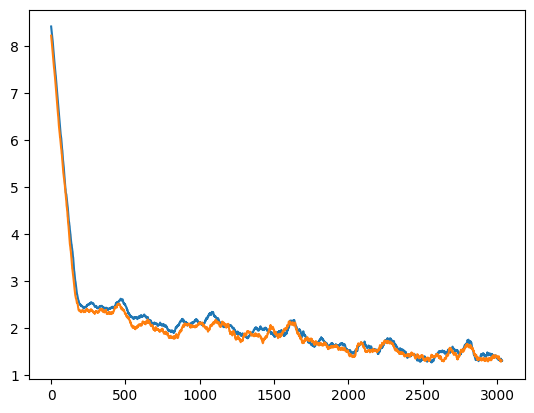

In [22]:
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
# plt.plot(model_en.loss_list)



In [23]:

train_features_reshape= torch.from_numpy(train_features.reshape(train_features.shape[0]//batch_size ,batch_size ,1024, 196)).to(dtype = torch.float32)
#Est ce que cette commande est réellement safe ? Demander !
train_data_fr = [tokenized_fr, train_features_reshape]
train_data_en = [tokenized_en, train_features_reshape]
# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model_fr,model_en,train_data_fr,train_data_en,200,batch_size, True,[1/2,1])


KeyboardInterrupt: 

In [ ]:
mixed_train(model_fr,model_en,tokenized_fr,tokenized_en,200,50, False,[1/2,1])

In [24]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map):
    model_en.eval()
    model_fr.eval()
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//batch_size)
j = np.random.randint(batch_size)
data,target = get_batch(tokenized_en, i)

print("Phrase à traduire : \n" + tensor_to_sentence(target[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr))


#%%

Phrase à traduire : 
a boy experiencing and exhibit at the museum . 
 Phrase traduite : 
 un un un TOKEN_VIDE une eue . urer . ee. eue eesdans ttztutilisant t. TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE 


In [ ]:
import pickle
with open("mypicklefile","rb") as f1 :
    data = pickle.load(f1)
# for i in range (data[0].size(1)-1):
#     print(data[0][i].norm())
#     print(i)
# data[0].norm()
# data[0][20].shape
# for i in range(data[1].size(0)):
#     print(i)
#     print(data[1][i])
    


In [ ]:
torch.save(model_fr.state_dict(), "model_fr")
torch.save(model_en.state_dict(), "model_en")
import os
import s3fs
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("model_fr","tordjx/model_fr")
fs.upload("model_en","tordjx/model_fr")